In [1]:
from ogb.lsc import PygPCQM4MDataset, PCQM4MDataset
from openbabel import pybel
from dscribe.descriptors import ACSF
from dscribe.core.system import System
from rdkit import Chem

import numpy as np
import pandas as pd
# from pandarallel import pandarallel

import torch

from pathlib import Path

from collections import defaultdict
import sys

# pandarallel.initialize(nb_workers=16, progress_bar=True)

In [2]:
orig_data = PygPCQM4MDataset(root = '../../data')
smiles_data = PCQM4MDataset(root="../../smiles_data", only_smiles=True)

In [3]:
# def make_unique_atom_dict(smiles_string):
#     rdkit_mol = Chem.MolFromSmiles(smiles_string)
#     for atom in rdkit_mol.GetAtoms():
#         unique_atom_dict[atom.GetSymbol()] += 1
#     return True

# unique_atom_dict = defaultdict(lambda: 0)
# smiles_df = pd.DataFrame({"smiles": smiles_data.graphs})
# _ = smiles_df["smiles"].parallel_apply(lambda x: make_unique_atom_dict(x))

In [4]:
# To run for unique atom check
# unique_atom_dict = defaultdict(lambda: 0)
# total = len(smiles_data)
# for idx, (smiles_string, _) in enumerate(smiles_data):
#     sys.stdout.write("\r{}/{}".format(idx+1, total))
#     sys.stdout.flush()
#     rdkit_mol = Chem.MolFromSmiles(smiles_string)
#     for atom in rdkit_mol.GetAtoms():
#         unique_atom_dict[atom.GetSymbol()] += 1

In [45]:
periodic_table = Chem.GetPeriodicTable()

def make_3D_mol_df(mol, drop_Hs=True):
    atom_symbols = []
    x_coords = []
    y_coords = []
    z_coords = []
    for atom in mol.atoms:
        atom_symbols.append(Chem.PeriodicTable.GetElementSymbol(periodic_table, atom.atomicnum))
        coords = list(atom.coords)
        x_coords.append(coords[0])
        y_coords.append(coords[1])
        z_coords.append(coords[2])
    mol_df = pd.DataFrame({"atom": atom_symbols, "x": x_coords, "y": y_coords, "z": z_coords})
    if drop_Hs:
        mol_df = mol_df[mol_df["atom"] != "H"].reset_index(drop=True)
    return mol_df

def get_atoms_rdkit(smiles_string):
    rdkit_mol = Chem.MolFromSmiles(smiles_string)
    rdkit_atom_symbols = []
    for atom in rdkit_mol.GetAtoms():
        rdkit_atom_symbols.append(atom.GetSymbol())
    return rdkit_atom_symbols

In [46]:
SYMBOL = ['C', 'N', 'O', 'F', 'S']
ACSF_GENERATOR = ACSF(
    species = SYMBOL,
    rcut = 10.0,
    g2_params=[[1, 2], [0.1, 2], [0.01, 2], [1, 6], [0.1, 6], [0.01, 6]],
    g4_params=[[1, 4,  1], [0.1, 4,  1], [0.01, 4,  1], [1, 4, -1], [0.1, 4, -1], [0.01, 4, -1]],
)

In [47]:
idx = int(np.random.choice(np.arange(len(smiles_data))))
total = len(smiles_data)
graphs = []
labels = []
for idx, (smiles_string, homolumogap) in enumerate(smiles_data):
    sys.stdout.write("\r{}/{}".format(idx+1, total))
    sys.stdout.flush()
    
    graph_features = orig_data[idx]

    assert homolumogap == graph_features.y

    mol = pybel.readstring('smi', smiles_string)
    mol.make3D()

    mol_df = make_3D_mol_df(mol)

    assert mol_df.atom.values.tolist() == get_atoms_rdkit(smiles_string)

    atoms = System(symbols=mol_df.atom.values.tolist(), positions=mol_df[['x', 'y', 'z']].values)
    acsf = ACSF_GENERATOR.create(atoms)

    assert graph_features.x.size()[0] == acsf.shape[0]
    
    graph_features.x = torch.cat([graph_features.x, torch.Tensor(acsf)], dim=1)
    
    graphs.append(graph_features)
    labels.append(homolumogap)
    
    if idx == 10:
        break
labels = np.array(labels)

5/3803453

ValueError: The following atomic numbers are not defined for this descriptor: {17}

In [48]:
get_atoms_rdkit(smiles_string)

['C',
 'C',
 'C',
 'N',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'Cl']

In [49]:
mol_df

,atom,x,y,z
0,C,0.811983,-0.142066,0.227273
1,C,2.152868,-0.146397,0.239493
2,C,3.204590,-0.582895,1.180150
3,N,4.653305,-0.354219,0.744362
4,C,5.170213,0.179077,-0.449348
5,O,6.396975,0.271304,-0.652567
6,C,4.435906,0.734387,-1.653950
7,C,5.563380,-0.812141,1.757888
8,C,6.912095,-0.825416,1.733927
9,C,7.836453,-1.339270,2.766208


In [ ]:
torch.save({'graphs': self.graphs, 'labels': self.labels}, pre_processed_file_path, pickle_protocol=4)

In [18]:
orig_data[idx]

Data(edge_attr=[40, 3], edge_index=[2, 40], x=[18, 9], y=[1])

In [12]:
.size()

torch.Size([18, 134])

In [13]:
graph_features.x.size()

torch.Size([18, 9])

In [127]:
acsf_features = [f'acsf_{i:03d}' for i in range(125)]
structures = []
# for idx, molecule_name in tqdm_notebook(enumerate(molecules), total=molecules.size):
atoms = System(symbols=mol_df.atom.values.tolist(), positions=mol_df[['x', 'y', 'z']].values)
acsf = ACSF_GENERATOR.create(atoms)
temp_df = pd.DataFrame(acsf, columns=acsf_features)
temp_df = pd.concat([mol_df, temp_df], axis=1)
structures.append(temp_df)

In [128]:
acsf.shape

(17, 125)

In [34]:
a.coords

(4.3547013416676785, 1.8986426326046093, 2.062458781271358)

In [35]:
a.type

'H'

In [22]:
print(mol.write('sdf'))


 OpenBabel06072112133D

 21 22  0  0  0  0  0  0  0  0999 V2000
    1.1747    0.0647    0.0725 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.3844   -0.0507    0.0488 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3559   -1.1051    0.0570 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.2599   -0.0983    0.0444 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3782    0.8544    0.0091 O   0  0  0  0  0  0  0  0  0  0  0  0
    5.7922   -0.0833    0.0820 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3631    1.2812    0.1256 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.1461    1.8666   -0.9414 C   0  0  0  0  0  3  0  0  0  0  0  0
    7.5481    3.1918   -0.5303 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.9459    3.4289    0.6488 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.2142    2.2351    1.0666 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.3985    2.1221    2.3042 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3884   -2.1823    0.0841 H   0  0  0  0  0  0  0  0  0  0  0  0
    6.1657   -0.6661   -0

In [7]:
from rdkit.Chem import PandasTools

In [8]:
frame = PandasTools.LoadSDF(f"{sdf_dir}/ex.sdf", smilesName="SMILES", molColName="Molecule", includeFingerprints=True)

,ID,SMILES,Molecule
0,,CC1=C(CC2=CC(=O)O2)[CH]C=C1,

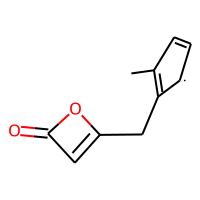

In [9]:
frame.

In [40]:
# mol = Chem.MolFromSmiles('O=C1C=CC(O1)C(c1ccccc1C)O')

In [44]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

my_mol = Chem.MolFromSmiles('O=C1C=CC(O1)C(c1ccccc1C)O')
my_mol_with_H=Chem.AddHs(my_mol)
AllChem.EmbedMolecule(my_mol_with_H)
AllChem.MMFFOptimizeMolecule(my_mol_with_H)
my_embedded_mol = Chem.RemoveHs(my_mol_with_H)
my_embedded_mol

print(Chem.MolToMolBlock(my_embedded_mol))   


     RDKit          3D

 15 16  0  0  0  0  0  0  0  0999 V2000
    2.9426    1.9752   -2.0212 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.6003    1.0492   -1.3101 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.2570   -0.2901   -1.7827 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9358   -1.0046   -0.7082 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0314   -0.1835    0.5239 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.4971    1.0876    0.0469 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.7321   -0.0134    1.3618 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5091    0.3515    0.5484 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6492    1.7097    0.1830 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7298    2.1575   -0.5757 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7031    1.2580   -0.9842 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5911   -0.0865   -0.6359 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4999   -0.5610    0.1188 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4822   -2.0264    0

In [43]:
print(m)


     RDKit          2D

 27 28  0  0  0  0  0  0  0  0999 V2000
   -0.0782   -7.0027    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.0365   -5.9990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5037   -6.3109    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.2537   -5.0118    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.2500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8797   -4.5072    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000   -2.5981    0

In [48]:
from openbabel import pybel

In [68]:
mol = pybel.readstring('smi','O=C1C=C(O1)C(c1cccc1C)')
mol.make3D()
mol.
print(mol.write('sdf'))


 OpenBabel06072111453D

 21 22  0  0  0  0  0  0  0  0999 V2000
    1.1983    0.1151    0.0415 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.4079   -0.0003    0.0178 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3794   -1.0547    0.0259 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.2834   -0.0479    0.0133 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.4017    0.9048   -0.0219 O   0  0  0  0  0  0  0  0  0  0  0  0
    5.8157   -0.0329    0.0509 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3866    1.3316    0.0945 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.1696    1.9170   -0.9725 C   0  0  0  0  0  3  0  0  0  0  0  0
    7.5716    3.2422   -0.5614 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.9694    3.4793    0.6177 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.2377    2.2855    1.0356 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.4220    2.1726    2.2731 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.4119   -2.1319    0.0530 H   0  0  0  0  0  0  0  0  0  0  0  0
    6.1892   -0.6157   -0


 OpenBabel06072111443D

 27 28  0  0  0  0  0  0  0  0999 V2000
   -1.8424   -0.0598   -0.6678 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6522    0.0721   -0.8246 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2932   -1.0533   -1.0202 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5060   -0.6052   -0.6735 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4562    0.8242   -0.2497 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0826    1.1893   -0.4852 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.0189    1.1899    1.2332 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5089    0.6328    2.6057 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9476    1.1577    3.8287 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4445    0.6547    5.0622 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4872   -0.3580    5.1266 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0410   -0.8874    3.9626 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5760   -0.4131    2.7742 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0079   -1.1282    1

In [1]:
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search

In [8]:
benzene = pubchem_atoms_search(smiles='O=C1C=CC(O1)C(c1ccccc1C)O')

/home/pv217/.conda/envs/ogb_lsc/lib/python3.8/site-packages/ase/data/pubchem.py:79: UserWarning: The structure "O=C1C=CC(O1)C(c1ccccc1C)O" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn('The structure "{}" has more than one '


In [9]:
benzene

Atoms(symbols='O3C12H12', pbc=False, initial_charges=...)

In [10]:
benzene = pubchem_atoms_conformer_search(smiles='O=C1C=CC(O1)C(c1ccccc1C)O')

In [12]:
benzene[2] == benzene[1]

False

In [17]:
benzene[5].get_positions()

array([[-2.4425e+00,  3.7810e-01, -7.8120e-01],
       [-2.4390e-01,  1.8207e+00, -7.9190e-01],
       [-4.6317e+00,  3.8970e-01, -7.0700e-02],
       [-1.9590e-01,  6.6390e-01,  4.3600e-02],
       [-1.2568e+00, -3.3110e-01, -3.9510e-01],
       [ 1.1964e+00,  7.6200e-02, -8.2000e-03],
       [ 2.3128e+00,  8.4550e-01,  3.1960e-01],
       [-1.7210e+00, -1.2085e+00,  7.0090e-01],
       [ 1.3551e+00, -1.2557e+00, -3.9060e-01],
       [-3.0175e+00, -1.0426e+00,  9.4010e-01],
       [ 3.5878e+00,  2.8280e-01,  2.6480e-01],
       [-3.4877e+00, -2.4800e-02, -4.0000e-04],
       [ 2.1678e+00,  2.2735e+00,  7.3190e-01],
       [ 2.6303e+00, -1.8185e+00, -4.4540e-01],
       [ 3.7467e+00, -1.0492e+00, -1.1750e-01],
       [-4.0230e-01,  1.0025e+00,  1.0673e+00],
       [-9.9400e-01, -8.8590e-01, -1.3003e+00],
       [-1.0985e+00, -1.9068e+00,  1.2417e+00],
       [ 5.5090e-01, -1.9330e+00, -6.4540e-01],
       [-3.6258e+00, -1.5435e+00,  1.6726e+00],
       [ 4.4681e+00,  8.6900e-01,  5.153

In [5]:
benzene.get_chemical_symbols()

['O',
 'O',
 'O',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H']